# Analysis of the Canadian Real Estate Market

2021 saw a boom in the canadian real estate market. This continued up until 2022 with many home owners selling their houses for up to 50% over the original price. If you are a home owner, you most likely had a realtor at your door, trying to convince you to sell your house.

To address this issue, the mortgage rates were increased in hopes, that it would crash the market by reducing the demand, which would then lead to reduction in house prices. But how successful has this strategy been?

My analysis would focus on the real estate market in **major cities ( > 200,000 population)** in the **Prairie & West Coast regions of Canada**.

I will use my analysis to answer the following questions:

- **How effective has the increase in mortgage rate been in crashing the market?**
- **What cities (in the Prairie & West Coast region had the highest demand?**
- **Where would you advise someone with limited funds to buy a house?**
- **How well can we predict the price of a house?**

## Data Collection

To answer these questions, I obtained data on:
   - Houses sold in Major cities in the Prairie & West Coast regions from **Sept 25, 2022 to January 23, 2023**. (*Source: honestdoor.ca*)
   - Population of major cities in the Prairie & West Coast regions in 2021 (*Source: Wikipedia*)
   - 5 - year fixed mortgage rates from September to January (*Source: ycharts.com*) 

**Read in the datasets**

In [2]:
import pandas as pd
import datetime
from matplotlib import dates, pyplot as plt
import matplotlib

In [3]:
#Get the house price data
house_data = pd.read_csv('canada_house_prices.csv').iloc[:,2:]

#Get the population data
population = pd.read_csv('population.txt', sep =',')

#Get the mortgage rates 
rates = pd.read_csv('mortgage_rates.txt', sep =',')

## Data Exploration

**Check out the house data**

In [38]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22432 entries, 0 to 22431
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22432 non-null  object 
 1   slug               22432 non-null  object 
 2   assessmentClass    22432 non-null  object 
 3   zoning             20049 non-null  object 
 4   accountNumber      18057 non-null  float64
 5   creaListing        127 non-null    object 
 6   bathroomsTotal     19417 non-null  float64
 7   bedroomsTotal      19388 non-null  float64
 8   livingArea         19911 non-null  float64
 9   lotSizeArea        18504 non-null  float64
 10  yearBuiltActual    21841 non-null  float64
 11  show               22432 non-null  bool   
 12  fireplace          1752 non-null   object 
 13  garageSpaces       9552 non-null   float64
 14  houseStyle         2525 non-null   object 
 15  livingAreaUnits    615 non-null    object 
 16  basement           260

**Observations from the data**

- The data contains information on 22,432 houses sold. 
- There are 30 columns with info such as the no of bathroomsTotal, bedroomsTotal,cityName, Province, closeDate, closePrice etc.
- Some columns have null values, which means that some info was not recorded for certain houses.

In [39]:
#convert the closeDate column to date object
house_data['closeDate'] = pd.to_datetime(house_data['closeDate']).dt.date
house_data['closeDate']

0        2022-11-15
1        2022-10-27
2        2022-12-14
3        2022-09-26
4        2022-12-27
            ...    
22427    2023-01-08
22428    2023-01-03
22429    2023-01-06
22430    2022-12-30
22431    2022-11-15
Name: closeDate, Length: 22432, dtype: object

In [40]:
#Now lets confirm the houses were sold between september 24, 2022 & January 23, 2023
date_min = house_data['closeDate'].min().strftime("%B %d,%Y")
date_max = house_data['closeDate'].max().strftime("%B %d,%Y")
no_of_days = str(house_data['closeDate'].max() - house_data['closeDate'].min()).split(',')[0]

In [41]:
print(f'Our data contains houses sold from {date_min} to {date_max}, which is a total of {no_of_days}.')

Our data contains houses sold from September 24,2022 to January 18,2023, which is a total of 116 days.


**Check out the population data**

In [42]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        8 non-null      object
 1   Province    8 non-null      object
 2   Population  8 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [43]:
population.head(3)

,City,Province,Population
0,Winnipeg,Manitoba,749607
1,Calgary,Alberta,1306784
2,Edmonton,Alberta,1010899


**Check out the mortgage rates**

In [44]:
rates.info() 
rates['date'] = pd.to_datetime(rates['date']).dt.date
#rates.set_index(keys='date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5 non-null      object 
 1   rate    5 non-null      float64
dtypes: float64(1), object(1)
memory usage: 208.0+ bytes


In [45]:
rates.head(3)

,date,rate
0,2022-09-01,5.58
1,2022-10-01,5.64
2,2022-11-01,5.75


## Now lets use the data to answer some questions

### 1. How effective has the increase in mortgage rate been in crashing the market?

To get an idea of the effect of the increase in mortgage rates on the market, I will look at the monthly number of houses sold & the average monthly prices of houses sold in each city

To get this, I will need to clean the data a bit.

**Data Preparation**

Because we only have data from september 25, we can not fully investigate this month. So I will remove houses sold in september from this dataset

In [17]:
#remove all houses sold in september from dataset
house_from_oct = house_data[house_data['closeDate'] >= datetime.date(2022,10,1)]
house_from_oct = house_from_oct.copy()
#confirm
house_from_oct['closeDate'].min()

datetime.date(2022, 10, 1)

Now since we want to get the data for each month, I will create a new column which will contain the month each house was sold

In [46]:
#create a function to get the first day of the month from each date

def get_first(date):
    
    """
    Input:
    date: date object
    output:
    This function returns the first day of the month
    """
    return date.replace(day=1)

#create another column to hold the month & year that the house was sold.
#The first day of the month will be used to represent each month

house_from_oct['closeMonth'] = house_from_oct['closeDate'].apply(get_first)
house_from_oct['closeMonth'].unique()

array([datetime.date(2022, 11, 1), datetime.date(2022, 10, 1),
       datetime.date(2022, 12, 1), datetime.date(2023, 1, 1)],
      dtype=object)

In [47]:
#create a function that will get the the number of houses sold & the avergae prices per month

def get_city_data(df, city_list):
    
    """
    Inputs:
    - df: dataframe object; the dataframe you are working with
    - city_list: list; the names of the city which you want to get data for
    
    Outputs:
    city_count: dict containing groupby objects of the no of houses sold in each city grouped by month
    city_avg: dict containing groupby objects of the average prices of houses sold in each city grouped by month
    """
    
    city_count_dict = {}
    city_avg_dict = {}
    
    for city in city_list:
        city_data = df[df['cityName'] == city]
        city_count = city_data.groupby(by='closeMonth')['closePrice'].count()
        city_avg = city_data.groupby(by='closeMonth')['closePrice'].mean()
        city_count_dict[city] = city_count
        city_avg_dict[city] = city_avg
    
    return city_count_dict, city_avg_dict

city_list = ['Winnipeg', 'Calgary', 'Edmonton', 'Vancouver', 'Surrey', 'Burnaby', 'Regina', 'Saskatoon']

cities_count, cities_avg = get_city_data(house_from_oct,city_list)

**Data Visualization**

Now lets look at what the data says

**How has the mortgage rate changed since September 2022?**

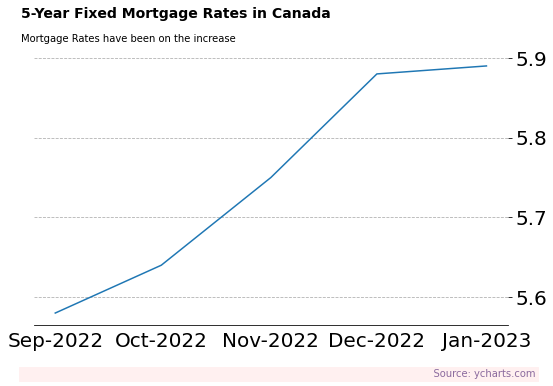

In [48]:
ax =rates.plot(x= 'date', y ='rate', legend=False,figsize=(8.5,5))
ax.set(xlabel='')
ax.xaxis.set_major_locator(dates.MonthLocator(interval =1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))
pos = ['left','right','top']
for char in pos:
    ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
ax.grid(axis='y', ls ='--')
ax.yaxis.tick_right()
ax.text(dates.date2num(datetime.date(2022, 9, 1))/1.0005,5.95,'5-Year Fixed Mortgage Rates in Canada',size=14, weight='bold')
ax.text(dates.date2num(datetime.date(2022, 9, 1))/1.0005,5.92,'Mortgage Rates have been on the increase',size=10)
ax.text(dates.date2num(datetime.date(2022, 9, 1))/1.0005,5.5, ' '*132 + 'Source: ycharts.com',color='#8B6A9E',backgroundcolor='#fff0f0',size=10)


plt.savefig('mortgage_rates_per_month.png', bbox_inches='tight',  facecolor='w')

We can see that the mortgage rate has been increasing since September 2022 till date. A total increase of 5% since september.

**Now how has this increase in rates affected the prices & demand for houses?**

Let's look at the number of houses sold from Oct till date

In [22]:
pd.crosstab(house_from_oct['cityName'], house_from_oct['closeMonth'])

closeMonth,2022-10-01,2022-11-01,2022-12-01,2023-01-01
cityName,,,,
Burnaby,246,108,94,4
Calgary,2146,3698,3764,376
Edmonton,2297,1858,2163,200
Regina,196,162,113,27
Saskatoon,220,212,158,58
Surrey,489,219,169,14
Vancouver,507,296,217,13
Winnipeg,542,418,247,118


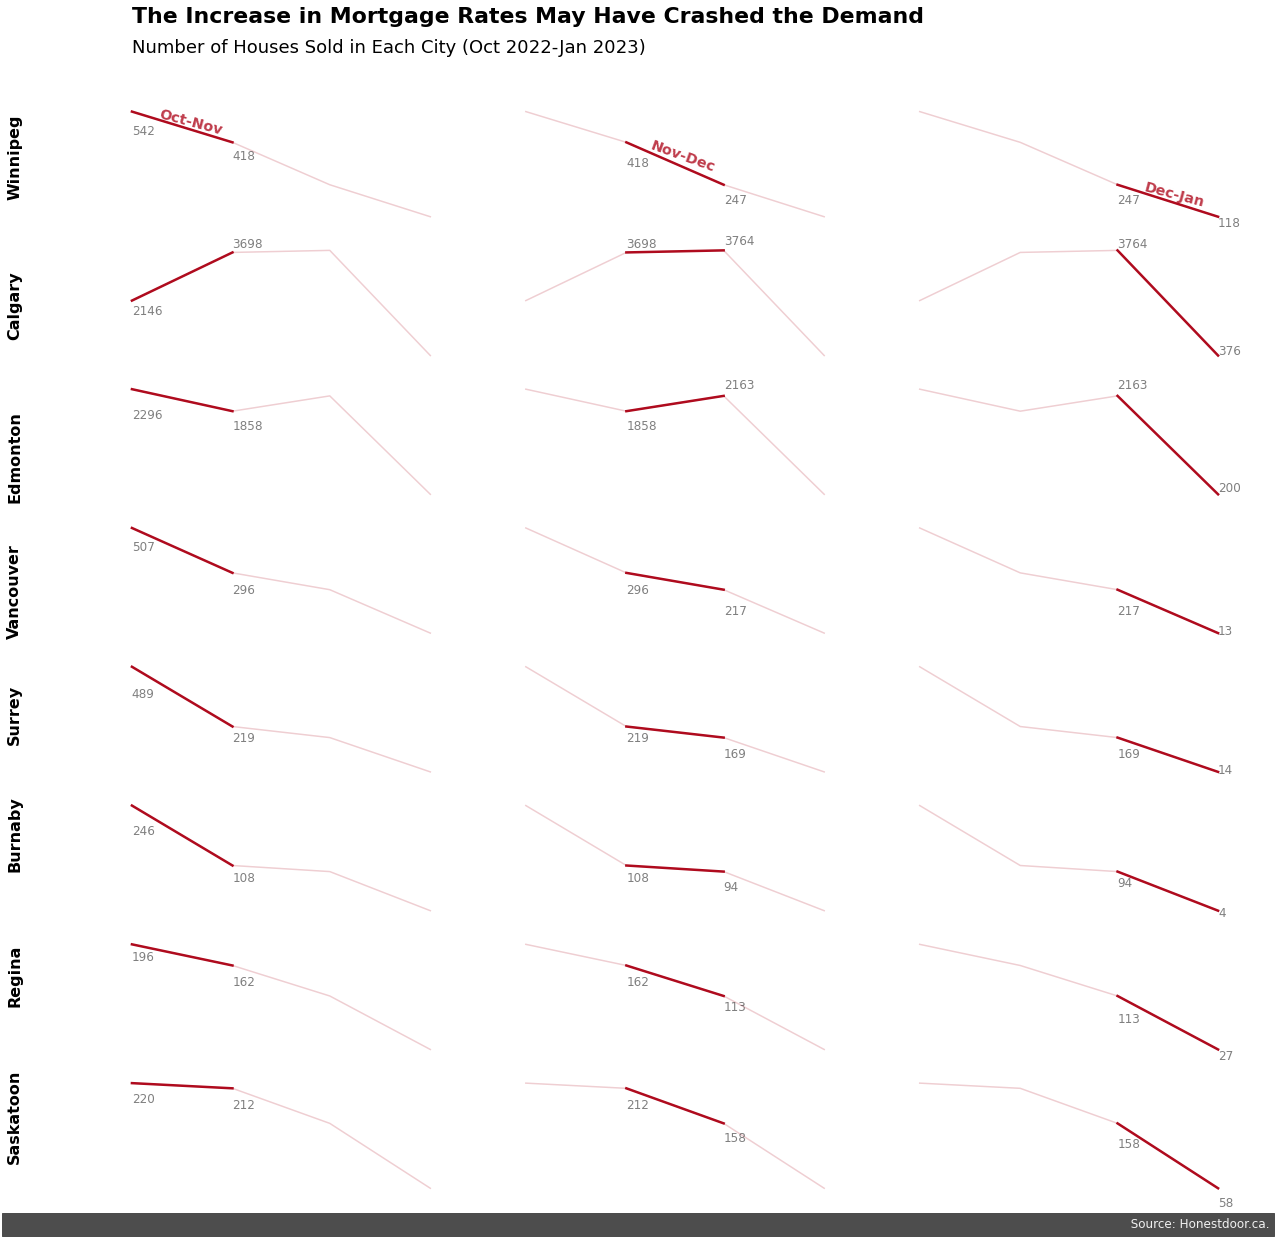

In [23]:


fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12),(ax13,ax14,ax15),(ax16,ax17,ax18),(ax19,ax20,ax21),(ax22,ax23,ax24)) = plt.subplots(ncols =3, nrows=8,figsize = (20,20))

#winnipeg
axes = [ax1,ax2,ax3]

for ax in axes:
    ax.plot(cities_count['Winnipeg'], color = '#af0b1e', alpha = 0.2, )
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax1.plot(cities_count['Winnipeg'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax2.plot(cities_count['Winnipeg'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax3.plot(cities_count['Winnipeg'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax1.text(dates.date2num(datetime.date(2022, 10, 1)), 450, '542', alpha=0.5, size='large')
ax1.text(dates.date2num(datetime.date(2022, 11, 1)), 350, '418', alpha=0.5, size='large')
ax1.text(dates.date2num(datetime.date(2022, 11, 1))/1.0012, 450, 'Oct-Nov', color='#af0b1e',weight='bold', rotation=-15, size='x-large', alpha =0.8)
ax2.text(dates.date2num(datetime.date(2022, 11, 1)), 320, '418', alpha=0.5, size='large')
ax2.text(dates.date2num(datetime.date(2022, 12, 1)), 170, '247', alpha=0.5, size='large')
ax2.text(dates.date2num(datetime.date(2022, 12, 1))/1.0012, 300, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=-20, size='x-large', alpha =0.8)
ax3.text(dates.date2num(datetime.date(2022, 12, 1)), 170, '247', alpha=0.5, size='large')
ax3.text(dates.date2num(datetime.date(2023, 1, 1)), 80, '118', alpha=0.5, size='large')
ax3.text(dates.date2num(datetime.date(2023, 1, 1))/1.0012, 160, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=-15, size='x-large', alpha =0.8)

#Now we will add subtitle & title
ax1.text(dates.date2num(datetime.date(2022, 10, 1)),900,'The Increase in Mortgage Rates May Have Crashed the Demand',size=22, weight='bold')
ax1.text(dates.date2num(datetime.date(2022, 10, 1)),780,'Number of Houses Sold in Each City (Oct 2022-Jan 2023)',size=18)
ax1.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,200,'Winnipeg',size=16, rotation=90, weight = 'bold')




#calgary
axes = [ax4,ax5,ax6]

for ax in axes:
    ax.plot(cities_count['Calgary'], color = '#af0b1e', alpha = 0.2)
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax4.plot(cities_count['Calgary'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax5.plot(cities_count['Calgary'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax6.plot(cities_count['Calgary'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax4.text(dates.date2num(datetime.date(2022, 10, 1)), 1700, '2146', alpha=0.5, size='large')
ax4.text(dates.date2num(datetime.date(2022, 11, 1)), 3850, '3698', alpha=0.5, size='large')
#ax4.text(dates.date2num(datetime.date(2022, 11, 1))/1.002, 2800, 'Oct-Nov', color='#af0b1e',weight='bold', rotation=5, size='x-large')
ax5.text(dates.date2num(datetime.date(2022, 11, 1)), 3850, '3698', alpha=0.5, size='large')
ax5.text(dates.date2num(datetime.date(2022, 12, 1)), 3950, '3764', alpha=0.5, size='large')
#ax5.text(dates.date2num(datetime.date(2022, 12, 1))/1.0013, 2800, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=0, size='x-large')
ax6.text(dates.date2num(datetime.date(2022, 12, 1)), 3850, '3764', alpha=0.5, size='large')
ax6.text(dates.date2num(datetime.date(2023, 1, 1)), 400, '376', alpha=0.5, size='large')
#ax6.text(dates.date2num(datetime.date(2023, 1, 1))/1.0005, 1500, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=10, size='x-large')
ax4.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,1000,'Calgary',size=16, rotation=90, weight = 'bold')


#Edmonton
axes = [ax7,ax8,ax9]

for ax in axes:
    ax.plot(cities_count['Edmonton'], color = '#af0b1e', alpha = 0.2)
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax7.plot(cities_count['Edmonton'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax8.plot(cities_count['Edmonton'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax9.plot(cities_count['Edmonton'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax7.text(dates.date2num(datetime.date(2022, 10, 1)), 1700, '2296', alpha=0.5, size='large')
ax7.text(dates.date2num(datetime.date(2022, 11, 1)), 1500, '1858', alpha=0.5, size='large')
#ax7.text(dates.date2num(datetime.date(2022, 11, 1))/1.0012, 2100, 'Oct-Nov', color='#af0b1e',weight='bold',rotation=-10, size='x-large')
ax8.text(dates.date2num(datetime.date(2022, 11, 1)), 1500, '1858', alpha=0.5, size='large')
ax8.text(dates.date2num(datetime.date(2022, 12, 1)), 2300, '2163', alpha=0.5, size='large')
#ax8.text(dates.date2num(datetime.date(2022, 12, 1))/1.0013, 2000, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=10, size='x-large')
ax9.text(dates.date2num(datetime.date(2022, 12, 1)), 2300, '2163', alpha=0.5, size='large')
ax9.text(dates.date2num(datetime.date(2023, 1, 1)), 250, '200', alpha=0.5, size='large')
#ax9.text(dates.date2num(datetime.date(2023, 1, 1))/1.0011, 800, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=-45, size='x-large')
ax7.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,100,'Edmonton',size=16, rotation=90, weight = 'bold')


#Vancouver
axes = [ax10,ax11,ax12]

for ax in axes:
    ax.plot(cities_count['Vancouver'], color = '#af0b1e', alpha = 0.2)
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax10.plot(cities_count['Vancouver'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax11.plot(cities_count['Vancouver'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax12.plot(cities_count['Vancouver'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax10.text(dates.date2num(datetime.date(2022, 10, 1)), 400, '507', alpha=0.5, size='large')
ax10.text(dates.date2num(datetime.date(2022, 11, 1)), 200, '296', alpha=0.5, size='large')
#ax10.text(dates.date2num(datetime.date(2022, 11, 1))/1.0012, 350, 'Oct-Nov', color='#af0b1e',weight='bold',rotation=-25, size='x-large')
ax11.text(dates.date2num(datetime.date(2022, 11, 1)), 200, '296', alpha=0.5, size='large')
ax11.text(dates.date2num(datetime.date(2022, 12, 1)), 100, '217', alpha=0.5, size='large')
#ax11.text(dates.date2num(datetime.date(2022, 12, 1))/1.0013, 270, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=-10, size='x-large')
ax12.text(dates.date2num(datetime.date(2022, 12, 1)), 100, '217', alpha=0.5, size='large')
ax12.text(dates.date2num(datetime.date(2023, 1, 1)), 5, '13', alpha=0.5, size='large')
#ax12.text(dates.date2num(datetime.date(2023, 1, 1))/1.0011, 80, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=-20, size='x-large')
ax10.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,0,'Vancouver',size=16, rotation=90, weight = 'bold')


#Surrey
axes = [ax13,ax14,ax15]

for ax in axes:
    ax.plot(cities_count['Surrey'], color = '#af0b1e', alpha = 0.2)
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax13.plot(cities_count['Surrey'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax14.plot(cities_count['Surrey'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax15.plot(cities_count['Surrey'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax13.text(dates.date2num(datetime.date(2022, 10, 1)), 350, '489', alpha=0.5, size='large')
ax13.text(dates.date2num(datetime.date(2022, 11, 1)), 150, '219', alpha=0.5, size='large')
#ax13.text(dates.date2num(datetime.date(2022, 11, 1))/1.0012, 300, 'Oct-Nov', color='#af0b1e',weight='bold',rotation=-35, size='x-large')
ax14.text(dates.date2num(datetime.date(2022, 11, 1)), 150, '219', alpha=0.5, size='large')
ax14.text(dates.date2num(datetime.date(2022, 12, 1)), 80, '169', alpha=0.5, size='large')
#ax14.text(dates.date2num(datetime.date(2022, 12, 1))/1.0013, 200, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=-5, size='x-large')
ax15.text(dates.date2num(datetime.date(2022, 12, 1)), 80, '169', alpha=0.5, size='large')
ax15.text(dates.date2num(datetime.date(2023, 1, 1)), 5, '14', alpha=0.5, size='large')
#ax15.text(dates.date2num(datetime.date(2023, 1, 1))/1.0011, 50, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=-20, size='x-large')
ax13.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,150,'Surrey',size=16, rotation=90, weight = 'bold')


#Burnaby
axes = [ax16,ax17,ax18]

for ax in axes:
    ax.plot(cities_count['Burnaby'], color = '#af0b1e', alpha = 0.2)
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax16.plot(cities_count['Burnaby'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax17.plot(cities_count['Burnaby'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax18.plot(cities_count['Burnaby'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax16.text(dates.date2num(datetime.date(2022, 10, 1)), 180, '246', alpha=0.5, size='large')
ax16.text(dates.date2num(datetime.date(2022, 11, 1)), 70, '108', alpha=0.5, size='large')
#ax16.text(dates.date2num(datetime.date(2022, 11, 1))/1.0012, 150, 'Oct-Nov', color='#af0b1e',weight='bold',rotation=-35, size='x-large')
ax17.text(dates.date2num(datetime.date(2022, 11, 1)), 70, '108', alpha=0.5, size='large')
ax17.text(dates.date2num(datetime.date(2022, 12, 1)), 50, '94', alpha=0.5, size='large')
#ax17.text(dates.date2num(datetime.date(2022, 12, 1))/1.0013, 105, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=-2.5, size='x-large')
ax18.text(dates.date2num(datetime.date(2022, 12, 1)), 60, '94', alpha=0.5, size='large')
ax18.text(dates.date2num(datetime.date(2023, 1, 1)), -10, '4', alpha=0.5, size='large')
#ax18.text(dates.date2num(datetime.date(2023, 1, 1))/1.0011, 30, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=-20, size='x-large')
ax16.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,100,'Burnaby',size=16, rotation=90, weight = 'bold')

#Regina
axes = [ax19,ax20,ax21]

for ax in axes:
    ax.plot(cities_count['Regina'], color = '#af0b1e', alpha = 0.2)
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax19.plot(cities_count['Regina'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax20.plot(cities_count['Regina'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax21.plot(cities_count['Regina'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax19.text(dates.date2num(datetime.date(2022, 10, 1)), 170, '196', alpha=0.5, size='large')
ax19.text(dates.date2num(datetime.date(2022, 11, 1)), 130, '162', alpha=0.5, size='large')
#ax19.text(dates.date2num(datetime.date(2022, 11, 1))/1.0012, 180, 'Oct-Nov', color='#af0b1e',weight='bold',rotation=-10, size='x-large')
ax20.text(dates.date2num(datetime.date(2022, 11, 1)), 130, '162', alpha=0.5, size='large')
ax20.text(dates.date2num(datetime.date(2022, 12, 1)), 90, '113', alpha=0.5, size='large')
#ax20.text(dates.date2num(datetime.date(2022, 12, 1))/1.0013, 130, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=-15, size='x-large')
ax21.text(dates.date2num(datetime.date(2022, 12, 1)), 70, '113', alpha=0.5, size='large')
ax21.text(dates.date2num(datetime.date(2023, 1, 1)), 10, '27', alpha=0.5, size='large')
#ax21.text(dates.date2num(datetime.date(2023, 1, 1))/1.0011, 50, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=-30, size='x-large')
ax19.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,100,'Regina',size=16, rotation=90, weight = 'bold')


#Saskatoon
axes = [ax22,ax23,ax24]

for ax in axes:
    ax.plot(cities_count['Saskatoon'], color = '#af0b1e', alpha = 0.2)
    ax.set(xlabel='')
    pos = ['left','right','top','bottom']
    for char in pos:
        ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([]) 
ax22.plot(cities_count['Saskatoon'][[0,1]],color='#af0b1e', linewidth=2.5) #oct to nov
ax23.plot(cities_count['Saskatoon'][[1,2]],color='#af0b1e', linewidth=2.5)#nove to dec
ax24.plot(cities_count['Saskatoon'][[2,3]],color='#af0b1e', linewidth=2.5) #dec to jan
ax22.text(dates.date2num(datetime.date(2022, 10, 1)), 190, '220', alpha=0.5, size='large')
ax22.text(dates.date2num(datetime.date(2022, 11, 1)), 180, '212', alpha=0.5, size='large')
#ax22.text(dates.date2num(datetime.date(2022, 11, 1))/1.0012, 215, 'Oct-Nov', color='#af0b1e',weight='bold',rotation=-5, size='x-large')
ax23.text(dates.date2num(datetime.date(2022, 11, 1)), 180, '212', alpha=0.5, size='large')
ax23.text(dates.date2num(datetime.date(2022, 12, 1)), 130, '158', alpha=0.5, size='large')
#ax23.text(dates.date2num(datetime.date(2022, 12, 1))/1.0013, 180, 'Nov-Dec', color='#af0b1e',weight='bold', rotation=-15, size='x-large')
ax24.text(dates.date2num(datetime.date(2022, 12, 1)), 120, '158', alpha=0.5, size='large')
ax24.text(dates.date2num(datetime.date(2023, 1, 1)), 30, '58', alpha=0.5, size='large')
#ax24.text(dates.date2num(datetime.date(2023, 1, 1))/1.0011, 90, 'Dec-Jan', color='#af0b1e',weight='bold', rotation=-30, size='x-large')
ax22.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,100,'Saskatoon',size=16, rotation=90, weight = 'bold')
ax22.text(dates.date2num(datetime.date(2022, 10, 1))/1.002,-2.9, ' '*290 + 'Source: Honestdoor.ca.',color='#f0f0f0',backgroundcolor='#4d4d4d',size=12)

plt.savefig('houses_sold_per_city.png')

**Observation**

- From the plot above we can see that the number of houses sold in most of the cities has been reducing since October 2022.
- However, the major cities in Alberta, Calgary & Alberta showed a different trend. 
- In Calgary, the number of houses sold kept increasing even with the increase in mortgage rate from October to December. However, there was drastic reduction in the number reduced by appoximately 90% in January. 
- Unlike other cities, Edmonton hasn't had a steady trend. The no of houses sold reduced by approximately 19% from Ocober to November but later increased by 14.1% from November to December and finally increased by just a little over by 90% from December to January.
- Overall, the no of houses sold in all the cities has reduced by at least 70% over the last  months.

**Conclusion**: There is evidence to show that the increase in rates has led to a reduction in demand for houses

**Can we say the same for the Prices?**

In [24]:
#Plot the Average prices for each city

In [25]:
grouped_avg = pd.crosstab(house_from_oct['cityName'], house_from_oct['closeMonth'], aggfunc ='mean', values = house_from_oct['closePrice'])
grouped_avg=grouped_avg.round(0)
grouped_avg.columns = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023']
grouped_avg

,Oct-2022,Nov-2022,Dec-2022,Jan-2023
cityName,,,,
Burnaby,1305339.0,1105072.0,1049663.0,667100.0
Calgary,550025.0,568786.0,561302.0,491524.0
Edmonton,404685.0,449809.0,444928.0,346480.0
Regina,313344.0,301715.0,266673.0,309581.0
Saskatoon,385900.0,372042.0,408113.0,365531.0
Surrey,1421484.0,971818.0,958983.0,849857.0
Vancouver,1572062.0,1375918.0,1353510.0,1035015.0
Winnipeg,368699.0,365617.0,355540.0,330470.0


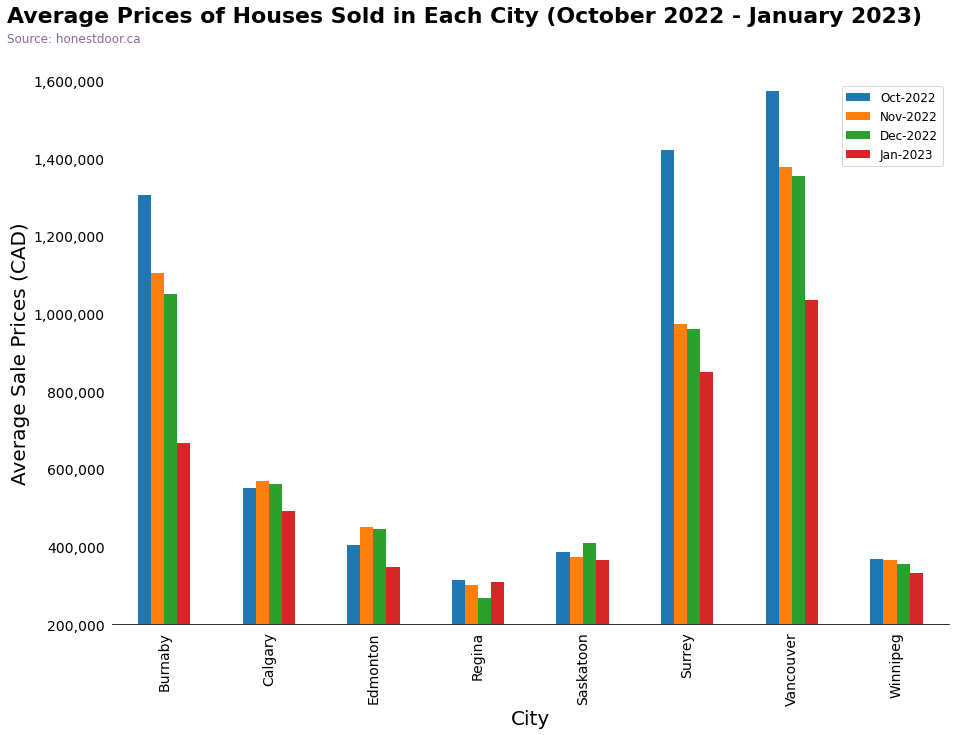

In [26]:
plt.rcParams.update({'font.size':20})
ax=grouped_avg.plot.bar(figsize=(15,10), ylim=(200000,1600000),xlabel = 'City', ylabel = 'Average Sale Prices (CAD)', fontsize=14)
ax.legend(fontsize=12, loc=0)
pos = ['left','right','top']
for char in pos:
    ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    
ax.text(-1.5, 1750000,'Average Prices of Houses Sold in Each City (October 2022 - January 2023)',size=22, weight='bold')
ax.text(-1.5, 1700000,'Source: honestdoor.ca' + ' '*170,color='#8B6A9E',size=12)


plt.savefig('avg_prices_per_city.png', bbox_inches='tight',  facecolor='w')

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

**Observation**

- In the Cities in British Columbia, the Average prices reduced each month, with at least 34% reduction from oct to jan
 - Average prices in Winnipeg also redcued month to month and approximately 10.3% reduction over the past 4 months
- In The two major cities in Alberta, Calgary & Edmonton, the average price increased from october to november but continued to decrease until january, with up to 14% reduction in Edmonton
- Overall the average prices of houses in the cities reduced between October, 2022 and January 2023. 

### Conclusion
From the analysis of this data, There is evidence that the increase in mortgage rates led to to a reduction in prices and demand for houses.

### 2. What Cities have the highest demand?

To have an idea of the city/cities with the highest demand for houses, I'll check the no of houses sold in each city during the period (oct to jan)

In [27]:
tables = pd.crosstab(house_from_oct['cityName'], house_from_oct['closeMonth'])
tables.sort_values(by = datetime.date(2022, 11, 1), inplace=True, ascending=False)
tables

closeMonth,2022-10-01,2022-11-01,2022-12-01,2023-01-01
cityName,,,,
Calgary,2146,3698,3764,376
Edmonton,2297,1858,2163,200
Winnipeg,542,418,247,118
Vancouver,507,296,217,13
Surrey,489,219,169,14
Saskatoon,220,212,158,58
Regina,196,162,113,27
Burnaby,246,108,94,4


- From the table above, it's clear that the number of houses sold in calgary in the past 4 months, is significantly higher than the other cities.

- So, it seems like Calgary has the highest demand 

### Why is there a considerably higher demand in Calgary?

One of the things that coul contribute to the demand in calgary, is the population. 

So to confirm, lets compare the population in Calgary to the population of people in the other cities

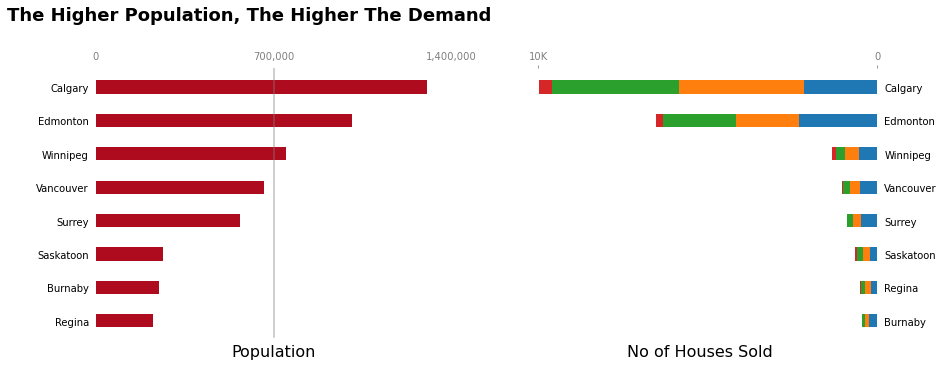

In [30]:
fig,(ax1,ax2) = plt.subplots(ncols =2, nrows=1,figsize = (14,5))
sorted_population = population.sort_values(by='Population',ascending=True)

ax1.barh(sorted_population['City'], sorted_population['Population'], height=0.4, color='#af0b1e')
ax1.set(xlabel='Population', ylabel ='')
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.xaxis.tick_top() 
ax1.tick_params(left=False, top=False) 
ax1.tick_params(axis='x',colors='grey')
ax1.set_xticks([0,700000,1400000])
ax1.set_xticklabels(['0', '700,000', '1,400,000'], fontdict = {'size':10} )
ax1.yaxis.set_tick_params(labelsize=10)
ax1.axvline(x=700000, ymin=0.01,c='grey', alpha=0.5)
ax1.text(x=-350000,y=9,s='The Higher Population, The Higher The Demand',size=18,weight='bold')

#ax1.text(x=-350000,y=10, s='Population of Major Cities in the Prairie & West Coast Region',size=14)
ax1.xaxis.label.set_fontsize(16)

sorted_counts = pd.crosstab(house_from_oct['cityName'], house_from_oct['closeMonth']).sort_values(by = datetime.date(2022, 11, 1), ascending=True)
sorted_counts.columns = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023']

ax2.yaxis.tick_right()
ax2.invert_xaxis()

ax2.barh(sorted_counts.index, sorted_counts['Oct-2022'], height=0.4)
ax2.barh(sorted_counts.index, sorted_counts['Nov-2022'], left = sorted_counts['Oct-2022'], height=0.4)
ax2.barh(sorted_counts.index, sorted_counts['Dec-2022'], left = sorted_counts['Nov-2022'] + sorted_counts['Oct-2022'], height=0.4)
ax2.barh(sorted_counts.index, sorted_counts['Jan-2023'], left = sorted_counts['Dec-2022'] + sorted_counts['Nov-2022'] + sorted_counts['Oct-2022'], height=0.4)
ax2.yaxis.set_tick_params(labelsize=10)

ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(right=False, top=False) 
ax2.xaxis.tick_top() 
ax2.tick_params(axis='x',colors='grey')
ax2.set_xticks([0,10000])
ax2.set_xticklabels(['0', '10K'], fontdict = {'size':10} )
ax2.set(xlabel='No of Houses Sold', ylabel ='')
ax2.xaxis.label.set_fontsize(16)


#ax2.text(x=-350000,y=11,s='Calgary has the Highest Population, with Edmonton Following Behind',size=18,weight='bold')
#ax1.text(x=-350000,y=10, s='Population of Major Cities in the Prairie & West Coast Region',size=14)


plt.savefig('population.png',bbox_inches='tight',  facecolor='w')


The plot above shows that there is a direct relationship between population and the number of houses sold.
So the high population in Calgary, may just be the reason why the demand for houses in that city if higher than demand in other cities.


**Let's take a closer look at the type of houses being sold in Calgary**

In [31]:
calgary_properties = house_from_oct[house_from_oct['cityName']=='Calgary']

In [32]:
property_type = pd.crosstab(calgary_properties['assessmentClass'], calgary_properties['closeMonth'],rownames = [''] )
property_type.columns = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023']
property_type.sort_values(by = 'Oct-2022', ascending=False, inplace=True)
property_type

,Oct-2022,Nov-2022,Dec-2022,Jan-2023
,,,,
Residential,1703,2818,2798,224
Condo,372,703,768,115
Commercial,55,148,171,37
Parking Lot,16,29,26,0
Other,0,0,1,0


From the data, it seems like most people are interested in residential buildings 

**How many bedrooms do people prefer?**

In [33]:
calgary_houses = calgary_properties[(calgary_properties['assessmentClass'] == 'Residential') | (calgary_properties['assessmentClass'] == 'Condo')]
calgary_houses['bedroomsTotal'].value_counts()
no_of_rooms = pd.crosstab(calgary_houses['bedroomsTotal'], calgary_houses['closeMonth'],rownames = [''] )
no_of_rooms.columns = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023']
no_of_rooms.index = ['1 - bedroom', '2-bedroom', '3-bedroom', '4-bedroom', '5-bedroom', '6-bedroom', '7-bedroom', '8-bedroom', '9-bedroom']
no_of_rooms.sort_values(by = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023'], ascending=False, inplace=True)
no_of_rooms

,Oct-2022,Nov-2022,Dec-2022,Jan-2023
3-bedroom,588,1003,975,96
4-bedroom,496,884,892,76
2-bedroom,371,634,715,86
5-bedroom,168,321,335,32
1 - bedroom,92,169,182,33
6-bedroom,39,66,71,11
7-bedroom,1,5,10,3
8-bedroom,1,4,3,0
9-bedroom,0,1,1,0


Most of the houses being sold in Calgary are 3 bedrooms & 4 bedrooms

**Now let's see if more people are buying newer houses or older houses**

We will create a new column called 'yearCat' and based on the year the house was built, would have any value in  2015 - 2023, 2000 - 2014, 1980 - 1999, 1960 - 1979 or Earlier than 1960 

In [34]:
#create a function to get 'yearCat' value based on the value 'yearBuiltActual'

def cat_year(year_built):
    
    """
    Inputs:
    year_built:the year the house was built 
    Output: 
    Any value in [2015 - 2023, 2000 - 2014, 1980 - 1999, 1960 - 1979, Earlier than 1960] indicating when the house was built
    """
    
    if year_built >= 2015:
        return '2015 - 2023'
    elif year_built >= 2000:
        return '2000 - 2014'
    elif year_built >= 1980:
        return '1980 - 1999'
    elif year_built >= 1960:
        return '1960 - 1979'
    else:
        return 'Earlier than 1960'
    
#create the new column with the 'cat_year function'
calgary_houses['yearCat'] = calgary_houses['yearBuiltActual'].apply(cat_year)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6656\3468428569.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calgary_houses['yearCat'] = calgary_houses['yearBuiltActual'].apply(cat_year)


In [35]:
#Now lets see the demand of the houses by the year category

demand_by_year = pd.crosstab(calgary_houses['yearCat'], calgary_houses['closeMonth'],rownames = [''], normalize='columns')
demand_by_year.columns = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023']
demand_by_year.sort_values(by = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023'], ascending=False, inplace=True)
demand_by_year

,Oct-2022,Nov-2022,Dec-2022,Jan-2023
,,,,
2000 - 2014,0.349880,0.366089,0.357543,0.315634
1980 - 1999,0.217349,0.228912,0.244812,0.212389
1960 - 1979,0.212530,0.208179,0.204992,0.203540
2015 - 2023,0.115181,0.117012,0.108805,0.171091
Earlier than 1960,0.105060,0.079807,0.083847,0.097345


In [36]:
neighbourhood_demand_perc = calgary_houses['neighbourhoodName'].value_counts(normalize=True)*100
neighbourhood_demand_perc = neighbourhood_demand_perc.apply(round, args = (2,))
neighbourhood_demand_perc[:10]

Cranston          2.03
Mckenzie Towne    1.96
Beltline          1.92
Evergreen         1.85
Auburn Bay        1.69
Mahogany          1.59
Evanston          1.57
Copperfield       1.53
Coventry Hills    1.51
Panorama Hills    1.47
Name: neighbourhoodName, dtype: float64

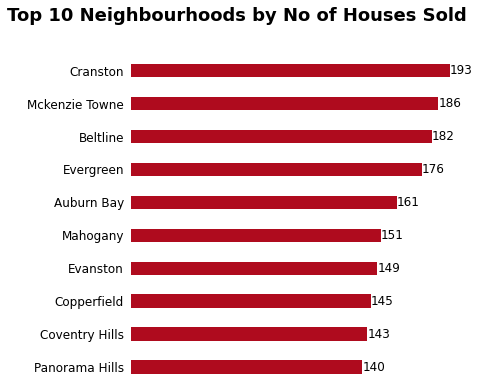

In [29]:
neighbourhood_demand = calgary_houses['neighbourhoodName'].value_counts()

ax = neighbourhood_demand[:10].sort_values(ascending=True).plot.barh(width=0.4, color='#af0b1e', fontsize=12, figsize=(6,6))
pos = ['left','right','top', 'bottom']
for char in pos:
    ax.spines[char].set_visible(False)
    ax.tick_params(left=False, bottom=False)

ax.text(-75, 10.5,'Top 10 Neighbourhoods by No of Houses Sold ',size=18, weight='bold')
ax.set_xticks([])
ax.bar_label(ax.containers[0], size=12)

plt.savefig('top_calgary_neigbourhoods.png',bbox_inches='tight',  facecolor='w');

### 3. Where would you advise someone with limited funds to buy a house?

My answer to this question will be based on why the person wants to buy the house.

Does the person want the house for residential or investment purposes?

If the person wants to buy the house for residential purposes, we would consider the prices of the houses in each of the cities
However, if the person wants to  invest, we would consider prices as well as demand.

**Where would you advise someone to buy a house for residential properties only?**


In [37]:
grouped_avg = pd.crosstab(house_from_oct['cityName'], house_from_oct['closeMonth'], aggfunc ='mean', values = house_from_oct['closePrice'])
grouped_avg=grouped_avg.round(0)
grouped_avg.columns = ['Oct-2022', 'Nov-2022', 'Dec-2022', 'Jan-2023']
grouped_avg

,Oct-2022,Nov-2022,Dec-2022,Jan-2023
cityName,,,,
Burnaby,1305339.0,1105072.0,1049663.0,667100.0
Calgary,550025.0,568786.0,561302.0,491524.0
Edmonton,404685.0,449809.0,444928.0,346480.0
Regina,313344.0,301715.0,266673.0,309581.0
Saskatoon,385900.0,372042.0,408113.0,365531.0
Surrey,1421484.0,971818.0,958983.0,849857.0
Vancouver,1572062.0,1375918.0,1353510.0,1035015.0
Winnipeg,368699.0,365617.0,355540.0,330470.0


In [32]:
house_from_oct['catYear'] = house_from_oct['yearBuiltActual'].apply(cat_year)

The two cities that have the lowest monthly average prices are Winnipeg & Regina but to decie on which city to buy a houes in, we will look at:
   - The value for money in each of the city (i.e are 3 bedroom houses in Winnipeg more expensive than 4 bedroom houses in Regina)
   - What city has newer houses for a lesser price?

In [33]:
winnipeg_regina = house_from_oct[((house_from_oct['cityName']=='Regina') | (house_from_oct['cityName']=='Winnipeg')) & ((house_from_oct['assessmentClass']=='Residential') | (house_from_oct['assessmentClass']=='Condo'))]
winnipeg_regina['bedroomsTotal']=winnipeg_regina['bedroomsTotal'].replace({1.0:'1-bedroom', 2.0:'2-bedroom', 3.0:'3-bedroom', 4.0:'4-bedroom', 5.0:'5-bedroom', 6.0:'6-bedroom', 7.0:'7-bedroom', 8.0:'8-bedroom', 9.0:'9-bedroom'})

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28012\861122986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winnipeg_regina['bedroomsTotal']=winnipeg_regina['bedroomsTotal'].replace({1.0:'1-bedroom', 2.0:'2-bedroom', 3.0:'3-bedroom', 4.0:'4-bedroom', 5.0:'5-bedroom', 6.0:'6-bedroom', 7.0:'7-bedroom', 8.0:'8-bedroom', 9.0:'9-bedroom'})


**In which city can a home buyer get a good value for their money?**

In [34]:
prices_per_room = (pd.crosstab(index = [winnipeg_regina['bedroomsTotal'], winnipeg_regina['catYear']], columns =  winnipeg_regina['cityName'], aggfunc ='mean', values = winnipeg_regina['closePrice'])).round(0)
prices_per_room

cityName                           Regina   Winnipeg
bedroomsTotal catYear                               
1-bedroom     1960 - 1979        103425.0   146515.0
              1980 - 1999        128686.0   156180.0
              2000 - 2014        154750.0   209500.0
              2015 - 2023             NaN   226817.0
              Earlier than 1960  100729.0   146294.0
2-bedroom     1960 - 1979        152350.0   227679.0
              1980 - 1999        234700.0   287632.0
              2000 - 2014        267670.0   299976.0
              2015 - 2023        277967.0   292641.0
              Earlier than 1960  165783.0   219538.0
3-bedroom     1960 - 1979        263784.0   329760.0
              1980 - 1999        368317.0   375198.0
              2000 - 2014        396440.0   463117.0
              2015 - 2023        380894.0   498217.0
              Earlier than 1960  250752.0   296504.0
4-bedroom     1960 - 1979        285807.0   390162.0
              1980 - 1999        412759.0   499018.0
              2000 - 2014        502308.0   604020.0
              2015 - 2023        535350.0   569225.0
              Earlier than 1960  261585.0   343982.0
5-bedroom     1960 - 1979        340350.0   423017.0
              1980 - 1999        463014.0   701947.0
              2000 - 2014        478367.0   680512.0
              2015 - 2023        587000.0   746644.0
              Earlier than 1960  359250.0   343261.0
6-bedroom     1960 - 1979        440650.0   515275.0
              1980 - 1999        538650.0        NaN
              2000 - 2014        627600.0   802317.0
              2015 - 2023        613900.0        NaN
              Earlier than 1960  242350.0   294522.0
7-bedroom     1960 - 1979        388000.0   417033.0
              1980 - 1999             NaN   524700.0
              2000 - 2014             NaN   624700.0
8-bedroom     2000 - 2014             NaN  1199400.0
9-bedroom     1980 - 1999             NaN   683800.0

From the above table, we see that houses witht he same no of bedrooms and which were built within the same period, have lower prices in Regina than in Winnipeg. 
So, Regina may be the best option.

**Which city should a Real Estate Investor buy a House?**

To advise an investor with this data. I'll look at:
 - The investor's budget - Investor A (with a budget of 500k CAD) & Investor B (with a budget of over 500k CAD)
 - Cities with low prices but high demand
 - what no of bedroom houses have a higher demand?
 - Houses in which year?
 - Value for money

In [35]:
#remove other property types and leave only residential & condo & bedrooms between 1  & 6
houses = house_from_oct[((house_from_oct['assessmentClass'] =='Residential') | (house_from_oct['assessmentClass'] =='Condo')) & ((house_from_oct['bedroomsTotal'] >= 1) & (house_from_oct['bedroomsTotal'] <= 6))]

#replace the categories in the bedroomsTotal column
houses['bedroomsTotal']=houses['bedroomsTotal'].replace({1.0:'1-bedroom', 2.0:'2-bedroom', 3.0:'3-bedroom', 4.0:'4-bedroom', 5.0:'5-bedroom', 6.0:'6-bedroom'})

houses['catYear'] = houses['yearBuiltActual'].apply(cat_year)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28012\3714732183.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['bedroomsTotal']=houses['bedroomsTotal'].replace({1.0:'1-bedroom', 2.0:'2-bedroom', 3.0:'3-bedroom', 4.0:'4-bedroom', 5.0:'5-bedroom', 6.0:'6-bedroom'})
C:\Users\ASUS\AppData\Local\Temp\ipykernel_28012\3714732183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['catYear'] = houses['yearBuiltActual'].apply(cat_year)


**For Investor A with a budget less than 500k, we will consider cities like Winnipeg, Regina, Saskatoon and Edmonton.**

These cities have had monthly average prices less than 500k in the past  months.

In [36]:
houses_less_500 = houses[houses.cityName.isin(['Winnipeg', 'Regina', 'Saskatoon', 'Edmonton'])]
cities_data_less_500 = (pd.crosstab(index = [houses_less_500['bedroomsTotal'], houses_less_500['catYear']], columns =  houses_less_500['cityName'], aggfunc =('count','mean'), values = houses_less_500['closePrice'])).round(0)
cities_data_less_500

count                                mean  \
cityName                        Edmonton Regina Saskatoon Winnipeg  Edmonton   
bedroomsTotal catYear                                                          
1-bedroom     1960 - 1979          102.0    4.0       NaN     13.0  115472.0   
              1980 - 1999           32.0    7.0       NaN      5.0  119309.0   
              2000 - 2014           79.0    2.0       NaN      1.0  156980.0   
              2015 - 2023           17.0    NaN       NaN      6.0  212065.0   
              Earlier than 1960     17.0    7.0       7.0     16.0  261386.0   
2-bedroom     1960 - 1979          139.0   12.0       1.0     33.0  170278.0   
              1980 - 1999          176.0    6.0       NaN     34.0  233053.0   
              2000 - 2014          459.0   23.0       NaN     21.0  237465.0   
              2015 - 2023           78.0    3.0       NaN     17.0  320131.0   
              Earlier than 1960     79.0   58.0      95.0    146.0  305575.0   
3-bedroom     1960 - 1979          317.0   51.0      40.0    174.0  279894.0   
              1980 - 1999          274.0   12.0      21.0     96.0  329529.0   
              2000 - 2014          765.0   35.0      21.0     41.0  408642.0   
              2015 - 2023          480.0   17.0       3.0     52.0  463574.0   
              Earlier than 1960    203.0   80.0     129.0    243.0  360117.0   
4-bedroom     1960 - 1979          331.0   42.0      61.0     93.0  413183.0   
              1980 - 1999          238.0   22.0      38.0     51.0  464571.0   
              2000 - 2014          395.0   25.0      34.0     40.0  538044.0   
              2015 - 2023          151.0    8.0       2.0     16.0  619150.0   
              Earlier than 1960    205.0   33.0      69.0     93.0  403194.0   
5-bedroom     1960 - 1979          149.0    6.0      28.0     18.0  443110.0   
              1980 - 1999          115.0    7.0      12.0     17.0  505213.0   
              2000 - 2014          136.0    9.0      30.0     25.0  631437.0   
              2015 - 2023           61.0    2.0       2.0      9.0  729886.0   
              Earlier than 1960     82.0   10.0      29.0     18.0  443132.0   
6-bedroom     1960 - 1979           33.0    2.0       1.0      4.0  489176.0   
              1980 - 1999           17.0    2.0       1.0      NaN  556735.0   
              2000 - 2014           46.0    1.0       2.0      6.0  774725.0   
              2015 - 2023            9.0    1.0       1.0      NaN  835789.0   
              Earlier than 1960     13.0    2.0       9.0      9.0  467684.0   

                                                                
cityName                           Regina  Saskatoon  Winnipeg  
bedroomsTotal catYear                                           
1-bedroom     1960 - 1979        103425.0        NaN  146515.0  
              1980 - 1999        128686.0        NaN  156180.0  
              2000 - 2014        154750.0        NaN  209500.0  
              2015 - 2023             NaN        NaN  226817.0  
              Earlier than 1960  100729.0   154443.0  146294.0  
2-bedroom     1960 - 1979        152350.0   284100.0  227679.0  
              1980 - 1999        234700.0        NaN  287632.0  
              2000 - 2014        267670.0        NaN  299976.0  
              2015 - 2023        277967.0        NaN  292641.0  
              Earlier than 1960  165783.0   227342.0  219538.0  
3-bedroom     1960 - 1979        263784.0   349058.0  329760.0  
              1980 - 1999        368317.0   365938.0  375198.0  
              2000 - 2014        396440.0   458519.0  463117.0  
              2015 - 2023        380894.0   501300.0  498217.0  
              Earlier than 1960  250752.0   333809.0  296504.0  
4-bedroom     1960 - 1979        285807.0   368151.0  390162.0  
              1980 - 1999        412759.0   429179.0  499018.0  
              2000 - 2014        502308.0   529206.0  604020.0  
              2015 - 2023    

From the data in table above, I observed the following:
    
- Most people have bought 3 bedrooms & 4 bedrooms houses within the past 4 months, so we can say these are the no of bedrooms that are really in demand.
- Edmonton has the overll highest demand across all the bedroom categories and year built categories
- Regina has the lowest demand while in Saskatoon, people are buying older houses (earlier than 1960) more than newer houses.
- The average prices for 3 bedroom and 4 bedroom houses in Edmonton is lower than in Winnipeg and Saskatoon.
- **Since, there is very low demand in Regina, It's advisable for this investor to buy a 3 bedroom or 4 bedroom house in Edmonton.**

**For Investor B with a budget over 500k, we will consider cities like Calgary, Vancouver, Burnaby and Surrey.**

These cities have had monthly average prices more than 500k in the past  months.

In [37]:
houses_more_500 = houses[houses.cityName.isin(['Calgary', 'Vancouver', 'Burnaby', 'Surrey'])]
cities_data_more_500 = (pd.crosstab(index = [houses_more_500['bedroomsTotal'], houses_more_500['catYear']], columns =  houses_more_500['cityName'], aggfunc =('count','mean'), values = houses_more_500['closePrice'])).round(0)
cities_data_more_500

count                                mean  \
cityName                        Burnaby Calgary Surrey Vancouver    Burnaby   
bedroomsTotal catYear                                                         
1-bedroom     1960 - 1979           8.0    63.0    NaN      46.0   399300.0   
              1980 - 1999          17.0    55.0   32.0      94.0   519994.0   
              2000 - 2014          20.0   238.0   34.0     119.0   547235.0   
              2015 - 2023          13.0    89.0   18.0      39.0   648654.0   
              Earlier than 1960     NaN    31.0    NaN       3.0        NaN   
2-bedroom     1960 - 1979          17.0   262.0   14.0      16.0   600759.0   
              1980 - 1999          67.0   357.0  121.0     128.0   653169.0   
              2000 - 2014          71.0   759.0   73.0     125.0   755997.0   
              2015 - 2023          24.0   318.0   32.0      25.0   867371.0   
              Earlier than 1960     3.0   110.0    6.0      13.0  1282633.0   
3-bedroom     1960 - 1979           8.0   489.0   27.0       6.0  1288238.0   
              1980 - 1999          21.0   641.0   65.0      38.0  1030348.0   
              2000 - 2014          15.0  1010.0   75.0      21.0   960373.0   
              2015 - 2023           6.0   345.0   25.0      34.0  1261167.0   
              Earlier than 1960    12.0   177.0    9.0      28.0  1571450.0   
4-bedroom     1960 - 1979          10.0   528.0   21.0       8.0  1368020.0   
              1980 - 1999          10.0   551.0   44.0      10.0  1888290.0   
              2000 - 2014          11.0   854.0   42.0       9.0  1571927.0   
              2015 - 2023           1.0   211.0   19.0      15.0  1149100.0   
              Earlier than 1960    10.0   204.0    6.0      41.0  1513190.0   
5-bedroom     1960 - 1979          11.0   247.0   11.0      13.0  1722209.0   
              1980 - 1999          10.0   256.0   19.0      15.0  2141660.0   
              2000 - 2014           2.0   233.0   31.0       7.0  2439200.0   
              2015 - 2023           2.0    50.0    5.0       5.0  3614550.0   
              Earlier than 1960     7.0    70.0    2.0      34.0  1641843.0   
6-bedroom     1960 - 1979           2.0    46.0    2.0       3.0  1719600.0   
              1980 - 1999           4.0    40.0   11.0      11.0  2112175.0   
              2000 - 2014           5.0    62.0   17.0       5.0  2777620.0   
              2015 - 2023           2.0    25.0    NaN       4.0  3664900.0   
              Earlier than 1960     NaN    14.0    1.0      14.0        NaN   

                                                                  
cityName                           Calgary     Surrey  Vancouver  
bedroomsTotal catYear                                             
1-bedroom     1960 - 1979         213950.0        NaN   541913.0  
              1980 - 1999         209150.0   390906.0   623695.0  
              2000 - 2014         234893.0   432944.0   676219.0  
              2015 - 2023         274743.0   475217.0   637662.0  
              Earlier than 1960   415555.0        NaN   558233.0  
2-bedroom     1960 - 1979         258359.0   544193.0   787356.0  
              1980 - 1999         332060.0   601764.0  1062198.0  
              2000 - 2014         334673.0   625564.0  1134371.0  
              2015 - 2023         352460.0   614844.0  1022344.0  
              Earlier than 1960   505221.0  2012183.0  1592523.0  
3-bedroom     1960 - 1979         403407.0  1262356.0  1488467.0  
              1980 - 1999         498278.0  1025595.0  1893329.0  
              2000 - 2014         569704.0   816497.0  1654276.0  
              2015 - 2023         706005.0   943712.0  1681143.0  
              Earlier than 1960   619091.0  1129533.0  2044289.0  
4-bedroom     1960 - 1979         574811.0  1267476.0  1941025.0  
              1980 - 1999         600608.0  1458991.0  2185730.0  
              2000 - 2014         743998.0  1136098.0  2592622.0  
              2015 

From the data in table above, I observed the following:
    
- Most people have bought 3 bedrooms & 4 bedrooms houses within the past 4 months, so we can say these are the no of bedrooms that are really in demand.
- Calgary has a significantly higher demand (across all the bedroom categories and year built categories) than in other cities
- Burnaby has the lowest demand.
- The average prices for houses in Calgary is as low as 30% of the avergae prices in the other cities
- **With all these insights from the data, It's advisable for this investor to buy a house in Calgary.**

**The last question on "How well can we predict the price of a house?" will be addressed in the "House_Price_Prediction
.ipynb" notebook**